In [1]:
#loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import cpi
import matplotlib.ticker as ticker

# setting plt to inline
%matplotlib inline

# updating cpi if flagged out of date
# cpi.update()

In [2]:
# importing sqlite3
import sqlite3

# conneting to db and creating cursor
conn = sqlite3.Connection('data/movies.db')
cur = conn.cursor()

# creating query functions
def fetcha(q):
    return cur.execute(q).fetchall()
def fetcho(q):
    return cur.execute(q).fetchone()

In [3]:
# getting table names
q = """SELECT name FROM sqlite_master 
WHERE type IN ('table','view') 
AND name NOT LIKE 'sqlite_%'
ORDER BY 1"""
fetcha(q)

[('bom_movie_gross',),
 ('imdb_name_basic',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('rotten_tomatoes_critic_reviews',),
 ('rotten_tomatoes_movies',),
 ('tmdb_movies',),
 ('tn_movie_budgets',)]

In [4]:
q = "PRAGMA table_info('rotten_tomatoes_movies')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'rotten_tomatoes_link', 'TEXT', 0, None, 0),
 (2, 'movie_title', 'TEXT', 0, None, 0),
 (3, 'movie_info', 'TEXT', 0, None, 0),
 (4, 'critics_consensus', 'TEXT', 0, None, 0),
 (5, 'content_rating', 'TEXT', 0, None, 0),
 (6, 'genres', 'TEXT', 0, None, 0),
 (7, 'directors', 'TEXT', 0, None, 0),
 (8, 'authors', 'TEXT', 0, None, 0),
 (9, 'actors', 'TEXT', 0, None, 0),
 (10, 'original_release_date', 'TEXT', 0, None, 0),
 (11, 'streaming_release_date', 'TEXT', 0, None, 0),
 (12, 'runtime', 'REAL', 0, None, 0),
 (13, 'production_company', 'TEXT', 0, None, 0),
 (14, 'tomatometer_status', 'TEXT', 0, None, 0),
 (15, 'tomatometer_rating', 'REAL', 0, None, 0),
 (16, 'tomatometer_count', 'REAL', 0, None, 0),
 (17, 'audience_status', 'TEXT', 0, None, 0),
 (18, 'audience_rating', 'REAL', 0, None, 0),
 (19, 'audience_count', 'REAL', 0, None, 0),
 (20, 'tomatometer_top_critics_count', 'INTEGER', 0, None, 0),
 (21, 'tomatometer_fresh_critics_count', 'INTEGER', 0, N

In [5]:
q = "PRAGMA table_info('tn_movie_budgets')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'id', 'INTEGER', 0, None, 0),
 (2, 'release_date', 'TEXT', 0, None, 0),
 (3, 'movie', 'TEXT', 0, None, 0),
 (4, 'production_budget', 'TEXT', 0, None, 0),
 (5, 'domestic_gross', 'TEXT', 0, None, 0),
 (6, 'worldwide_gross', 'TEXT', 0, None, 0)]

In [6]:
# creating initial dataframe by joining the four tables and printing first row
q = """SELECT*FROM rotten_tomatoes_movies AS rt
       JOIN tn_movie_budgets AS tn
       ON rt.movie_title = tn.movie
       
       """
df = pd.DataFrame(fetcha(q))
df.columns = [i[0] for i in cur.description]   

In [7]:
# # dropping extraneous columns
# df = df.drop(['idx', 'rotten_tomatoes_link', 'movie_info', 'critics_consensus', 'directors',\
#              'authors', 'actors', 'original_release_date', 'streaming_release_date',\
#              'runtime', 'production_company', 'tomatometer_status', 'tomatometer_rating',\
#              'tomatometer_count', 'audience_status', 'audience_rating', 'audience_count',\
#              'id', 'movie'], axis=1)
# df.head(1)

In [8]:
df.columns

Index(['idx', 'rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'idx', 'id', 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross'],
      dtype='object')

In [9]:
df.actors.isna().sum()

14

In [10]:
df['actors'] = df['actors'].fillna('NaN')

In [11]:
# change date string to datetime object 
df.release_date = pd.to_datetime(df.release_date)
df['year'] = df['release_date'].apply(lambda x: x.year)
df['month'] = df['release_date'].apply(lambda x: x.month)

In [12]:
#cleaning numerical strings and converting to floats
df['worldwide_gross'] = df['worldwide_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
df['domestic_gross'] = df['domestic_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
df['production_budget'] = df['production_budget']\
                                             .apply(lambda x: x.strip("$")\
                                             .replace(',', '')).astype('float')

In [13]:
df['international_gross'] = df['worldwide_gross'].sub(df['domestic_gross'])

In [14]:
df['domestic_net'] = df['domestic_gross'].sub(df['production_budget'])
df['worldwide_net'] = df['worldwide_gross'].sub(df['production_budget'])
df['international_net'] = df['international_gross'].sub(df['production_budget'])

In [15]:
df['domestic_roi'] = df['domestic_net'].divide(df['production_budget'])
df['worldwide_roi'] = df['worldwide_net'].divide(df['production_budget'])
df['international_roi'] = df['international_net'].divide(df['production_budget'])

In [16]:
#adding adjust net profit columns
df['adj_dom_gross'] = df.apply(lambda x: cpi.inflate(x.domestic_gross, x.year), axis=1)
df['adj_ww_gross'] = df.apply(lambda x: cpi.inflate(x.worldwide_gross, x.year), axis=1)
df['adj_i_gross'] = df.apply(lambda x: cpi.inflate(x.international_gross, x.year), axis=1)
df['adj_prod_budg'] = df.apply(lambda x: cpi.inflate(x.production_budget, x.year), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4776 entries, 0 to 4775
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   idx                               4776 non-null   int64         
 1   rotten_tomatoes_link              4776 non-null   object        
 2   movie_title                       4776 non-null   object        
 3   movie_info                        4741 non-null   object        
 4   critics_consensus                 4134 non-null   object        
 5   content_rating                    4776 non-null   object        
 6   genres                            4776 non-null   object        
 7   directors                         4724 non-null   object        
 8   authors                           4657 non-null   object        
 9   actors                            4776 non-null   object        
 10  original_release_date             4712 non-null 

In [17]:
#adding net profit columns
df['adj_dom_net'] = df['adj_dom_gross'].sub(df['adj_prod_budg'])
df['adj_ww_net'] = df['adj_ww_gross'].sub(df['adj_prod_budg'])
df['adj_i_net'] = df['adj_i_gross'].sub(df['adj_prod_budg'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4776 entries, 0 to 4775
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   idx                               4776 non-null   int64         
 1   rotten_tomatoes_link              4776 non-null   object        
 2   movie_title                       4776 non-null   object        
 3   movie_info                        4741 non-null   object        
 4   critics_consensus                 4134 non-null   object        
 5   content_rating                    4776 non-null   object        
 6   genres                            4776 non-null   object        
 7   directors                         4724 non-null   object        
 8   authors                           4657 non-null   object        
 9   actors                            4776 non-null   object        
 10  original_release_date             4712 non-null 

In [18]:
#adding return on investment columns and checking results
df['adj_dom_roi'] = df['adj_dom_net'].divide(df['adj_prod_budg'])
df['adj_ww_roi'] = df['adj_ww_net'].divide(df['adj_prod_budg'])
df['adj_i_roi'] = df['adj_i_net'].divide(df['adj_prod_budg'])
df.head(1)

,idx,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,...,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_prod_budg,adj_dom_net,adj_ww_net,adj_i_net,adj_dom_roi,adj_ww_roi,adj_i_roi
0,0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",...,1.040753e+08,2.615132e+08,1.574379e+08,1.113815e+08,-7.306274e+06,1.501316e+08,4.605635e+07,-0.065597,1.347904,0.413501


In [19]:
df.columns

Index(['idx', 'rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'idx', 'id', 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'year', 'month',
       'international_gross', 'domestic_net', 'worldwide_net',
       'international_net', 'domestic_roi', 'worldwide_roi',
       'international_roi', 'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross',
       'adj_prod_budg', 'adj_dom_net', 'adj_ww_net', 'adj_i_net',
       'adj_dom_roi', 'adj_ww_roi', 'adj_i_roi'],
      dtype='object')

In [20]:
df = df.rename(columns = {'movie_title':'title', 'release_date':'date',\
                          'content_rating': 'rating', 'genres': 'genres',\
                          'tomatometer_top_critics_count': 'top', 'tomatometer_fresh_critics_count': 'fresh',\
                          'tomatometer_rotten_critics_count': 'rotten'})
df.columns

Index(['idx', 'rotten_tomatoes_link', 'title', 'movie_info',
       'critics_consensus', 'rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'top', 'fresh', 'rotten', 'idx', 'id', 'date',
       'movie', 'production_budget', 'domestic_gross', 'worldwide_gross',
       'year', 'month', 'international_gross', 'domestic_net', 'worldwide_net',
       'international_net', 'domestic_roi', 'worldwide_roi',
       'international_roi', 'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross',
       'adj_prod_budg', 'adj_dom_net', 'adj_ww_net', 'adj_i_net',
       'adj_dom_roi', 'adj_ww_roi', 'adj_i_roi'],
      dtype='object')

## Top 100 Films by Worldwide Gross

In [21]:
title_gross = df[['title', 'production_budget', 'worldwide_gross', 'worldwide_net', 'worldwide_roi', 'genres', 'year', 'month']]
unique_gross_titles = title_gross.drop_duplicates(subset = ['title'])
top100_gross_films = unique_gross_titles.sort_values(by='worldwide_gross', ascending=False).head(100)
top100_gross_films

,title,production_budget,worldwide_gross,worldwide_net,worldwide_roi,genres,year,month
1019,Avatar,425000000.0,2.776345e+09,2.351345e+09,5.532577,"Action & Adventure, Comedy, Mystery & Suspense...",2009,12
367,Titanic,200000000.0,2.208208e+09,2.008208e+09,10.041042,"Action & Adventure, Classics, Drama, Romance",1997,12
1021,Avengers: Infinity War,300000000.0,2.048134e+09,1.748134e+09,5.827114,"Action & Adventure, Science Fiction & Fantasy",2018,4
2531,Jurassic World,215000000.0,1.648855e+09,1.433855e+09,6.669092,"Action & Adventure, Mystery & Suspense, Scienc...",2015,6
2017,Furious 7,190000000.0,1.518723e+09,1.328723e+09,6.993278,"Action & Adventure, Mystery & Suspense",2015,4
...,...,...,...,...,...,...,...,...
2437,Interstellar,165000000.0,6.663794e+08,5.013794e+08,3.038663,"Action & Adventure, Science Fiction & Fantasy",2014,11
2608,Kung Fu Panda 2,150000000.0,6.648375e+08,5.148375e+08,3.432250,"Action & Adventure, Animation, Comedy, Kids & ...",2011,5
2541,Justice League,300000000.0,6.559452e+08,3.559452e+08,1.186484,"Action & Adventure, Drama, Science Fiction & F...",2017,11
4222,The Martian,108000000.0,6.552714e+08,5.472714e+08,5.067328,Science Fiction & Fantasy,2015,10


In [22]:
title_adj_gross = df[['title', 'adj_prod_budg', 'adj_ww_gross', 'adj_ww_net', 'adj_ww_roi', 'genres', 'year', 'month']]
unique_adj_titles = title_adj_gross.drop_duplicates(subset = ['title'])
top100_adj_gross_films = unique_adj_titles.sort_values(by='adj_ww_gross', ascending=False).head(100)
top100_adj_gross_films

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,adj_ww_roi,genres,year,month
1054,Bambi,1.345728e+07,4.203440e+09,4.189983e+09,311.354312,"Animation, Classics, Kids & Family, Science Fi...",1942,8
367,Titanic,3.185757e+08,3.517408e+09,3.198832e+09,10.041042,"Action & Adventure, Classics, Drama, Romance",1997,12
1019,Avatar,5.064591e+08,3.308483e+09,2.802024e+09,5.532577,"Action & Adventure, Comedy, Mystery & Suspense...",2009,12
357,Snow White and the Seven Dwarfs,2.641789e+07,3.283159e+09,3.256741e+09,123.277880,"Animation, Classics, Kids & Family, Science Fi...",1937,12
1834,The Exorcist,6.909649e+07,2.465676e+09,2.396580e+09,34.684540,"Classics, Horror",1973,12
...,...,...,...,...,...,...,...,...
4532,Up,2.085420e+08,8.716619e+08,6.631199e+08,3.179791,"Action & Adventure, Animation, Comedy, Kids & ...",2009,5
990,Armageddon,2.195827e+08,8.698612e+08,6.502785e+08,2.961429,"Action & Adventure, Mystery & Suspense, Scienc...",1998,7
297,Venom,1.181019e+08,8.690962e+08,7.509943e+08,6.358867,"Cult Movies, Horror, Mystery & Suspense",2018,10
4716,Wonder Woman,1.564481e+08,8.564315e+08,6.999835e+08,4.474223,"Action & Adventure, Animation, Drama, Kids & F...",2017,6


In [23]:
top100_gross_films.describe()

,production_budget,worldwide_gross,worldwide_net,worldwide_roi,year,month
count,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000
mean,1.685750e+08,9.576570e+08,7.890820e+08,5.846388,2011.340000,7.250000
std,7.397127e+07,3.273300e+08,3.019174e+08,3.688244,6.067333,2.903759
min,3.500000e+07,6.522201e+08,3.559452e+08,1.186484,1993.000000,2.000000
25%,1.100000e+08,7.578371e+08,6.014434e+08,3.236404,2009.000000,5.000000
50%,1.725000e+08,8.794230e+08,7.003720e+08,4.513429,2013.000000,6.000000
75%,2.000000e+08,1.040525e+09,8.783895e+08,7.029846,2016.000000,11.000000
max,4.250000e+08,2.776345e+09,2.351345e+09,18.927371,2019.000000,12.000000


In [24]:
top100_adj_gross_films.describe()

,adj_prod_budg,adj_ww_gross,adj_ww_net,adj_ww_roi,year,month
count,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000
mean,1.687481e+08,1.277631e+09,1.108883e+09,16.019202,2001.810000,7.580000
std,9.581017e+07,5.732113e+08,5.769721e+08,39.681137,17.395399,3.012365
min,4.493093e+06,8.547247e+08,6.252047e+08,1.546673,1937.000000,2.000000
25%,8.805160e+07,9.490569e+08,8.062123e+08,4.006988,1994.000000,5.000000
50%,1.792323e+08,1.115988e+09,9.634766e+08,5.697061,2008.500000,7.000000
75%,2.201631e+08,1.304167e+09,1.156453e+09,11.970308,2015.000000,11.000000
max,5.064591e+08,4.203440e+09,4.189983e+09,311.354312,2019.000000,12.000000


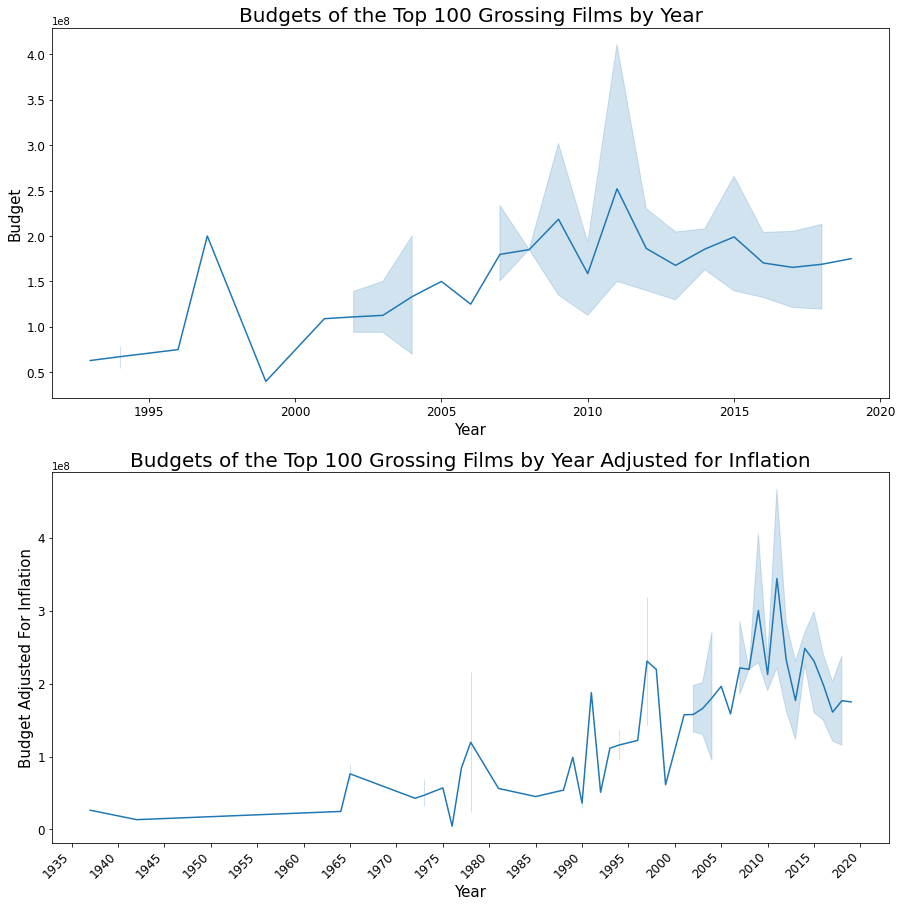

In [25]:
fig, (ax1, ax2 ) = plt.subplots(2, 1, figsize=(15,15))
sns.lineplot(x='year', y='production_budget', data=top100_gross_films, ax=ax1)
sns.lineplot(x='year', y='adj_prod_budg', data=top100_adj_gross_films, ax=ax2)
# adjusting xticks
plt.xticks(rotation=45, ha='right')
ax1.tick_params(labelsize=12) 
ax2.tick_params(labelsize=12)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax2.xaxis.set_major_formatter(ticker.ScalarFormatter())

# label for x-axis 
ax1.set_xlabel( "Year", size = 15 )
ax2.set_xlabel( "Year", size = 15 ) 
# label for y-axis 
ax1.set_ylabel( "Budget", size = 15 ) 
ax2.set_ylabel( "Budget Adjusted For Inflation", size = 15 ) 
# title for plot 
ax1.set_title( "Budgets of the Top 100 Grossing Films by Year" , size = 20 )
ax2.set_title( "Budgets of the Top 100 Grossing Films by Year Adjusted for Inflation" , size = 20 ) 
plt.show()

In [26]:
t100_count_by_year = pd.DataFrame(top100_gross_films.year.value_counts()).reset_index()
t100_count_by_year = t100_count_by_year.rename(columns= {'index': 'year', 'year': 'count'})
t100_count_by_year.head(1)

,year,count
0,2017,11


In [27]:
t100_adj_count_by_year = pd.DataFrame(top100_adj_gross_films.year.value_counts()).reset_index()
t100_adj_count_by_year = t100_adj_count_by_year.rename(columns= {'index': 'year', 'year': 'count'})
t100_adj_count_by_year.head(1)

,year,count
0,2017,7


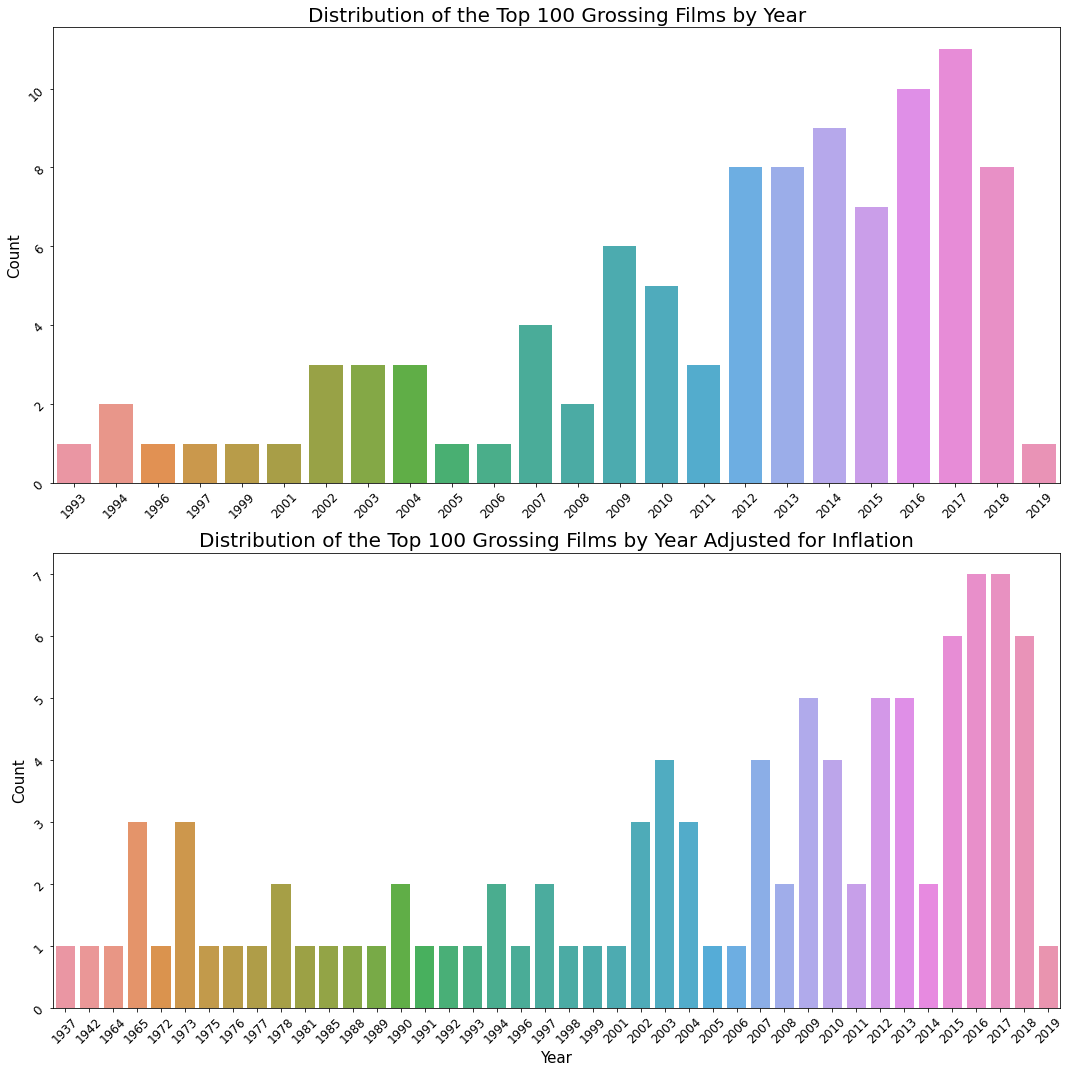

In [28]:
fig, (ax1, ax2 ) = plt.subplots(2, 1, figsize=(15,15))
sns.barplot(x='year', y= 'count', data=t100_count_by_year, ax = ax1)
sns.barplot(x='year', y= 'count', data=t100_adj_count_by_year, ax = ax2)
# adjusting xticks
for ax in fig.axes:
    ax.tick_params(labelrotation=45)
ax1.tick_params(labelsize=12) 
ax2.tick_params(labelsize=12)
# label for x-axis 
ax1.set_xlabel( "", size = 15 )
ax2.set_xlabel( "Year", size = 15 ) 
# label for y-axis 
ax1.set_ylabel( "Count", size = 15 ) 
ax2.set_ylabel( "Count", size = 15 ) 
# title for plot 
ax1.set_title( "Distribution of the Top 100 Grossing Films by Year" , size = 20 )
ax2.set_title( "Distribution of the Top 100 Grossing Films by Year Adjusted for Inflation" , size = 20 )
plt.tight_layout()
# render
plt.show()

In [29]:
t100_gross_by_roi = top100_gross_films.sort_values(by='worldwide_roi', ascending=False)
t100_gross_by_roi.head()

,title,production_budget,worldwide_gross,worldwide_net,worldwide_roi,genres,year,month
198,It,35000000.0,6.974580e+08,6.624580e+08,18.927371,"Classics, Comedy, Drama, Romance",2017,9
3711,The Sixth Sense,40000000.0,6.728063e+08,6.328063e+08,15.820157,Mystery & Suspense,1999,8
2529,Jurassic Park,63000000.0,1.038813e+09,9.758126e+08,15.489089,"Action & Adventure, Mystery & Suspense, Scienc...",1993,6
1226,Bohemian Rhapsody,55000000.0,8.949853e+08,8.399853e+08,15.272461,Drama,2018,11
2929,Minions,74000000.0,1.160336e+09,1.086336e+09,14.680219,"Animation, Comedy, Kids & Family",2015,7


In [30]:
t100_adj_gross_by_roi = top100_adj_gross_films.sort_values(by='adj_ww_roi', ascending=False)
t100_adj_gross_by_roi.head()

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,adj_ww_roi,genres,year,month
1054,Bambi,1.345728e+07,4.203440e+09,4.189983e+09,311.354312,"Animation, Classics, Kids & Family, Science Fi...",1942,8
270,Rocky,4.493093e+06,1.010946e+09,1.006453e+09,224.000000,"Drama, Sports & Fitness",1976,11
357,Snow White and the Seven Dwarfs,2.641789e+07,3.283159e+09,3.256741e+09,123.277880,"Animation, Classics, Kids & Family, Science Fi...",1937,12
2114,Grease,2.352672e+07,1.519474e+09,1.495947e+09,63.585030,"Comedy, Musical & Performing Arts, Romance",1978,6
2090,Goldfinger,2.474100e+07,1.030050e+09,1.005309e+09,40.633333,"Action & Adventure, Classics, Mystery & Suspense",1964,12


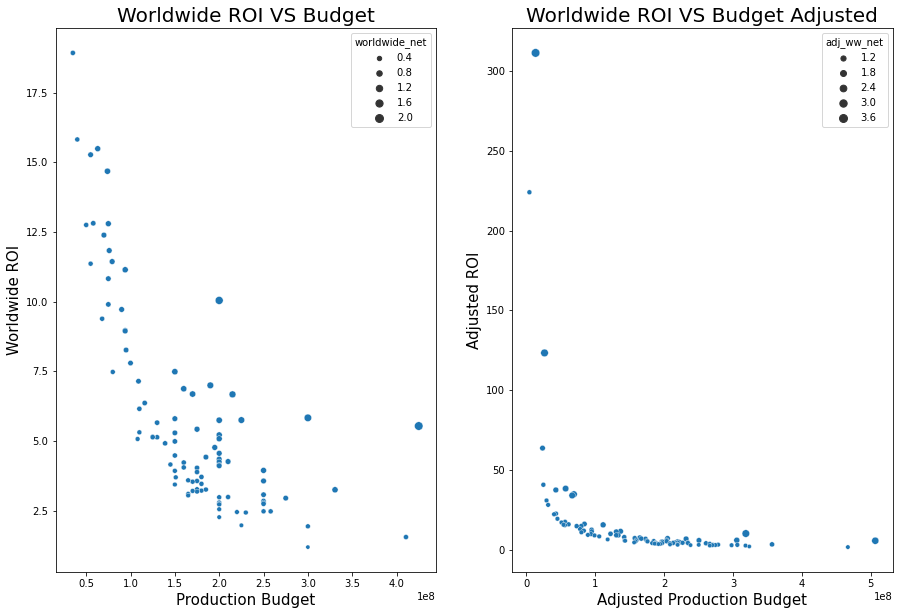

In [31]:
fig, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(15,10))

sns.scatterplot(x='production_budget', y='worldwide_roi', data=top100_gross_films, size='worldwide_net', ax=ax1)

sns.scatterplot(x='adj_prod_budg', y='adj_ww_roi', data=top100_adj_gross_films, size='adj_ww_net', ax=ax2)

#label for x-axis 
ax1.set_xlabel( "Production Budget" , fontsize=15 )
ax2.set_xlabel("Adjusted Production Budget", fontsize=15)
#label for y-axis 
ax1.set_ylabel( "Worldwide ROI", fontsize=15)
ax2.set_ylabel("Adjusted ROI", fontsize=15)
# setting title
ax1.set_title("Worldwide ROI VS Budget", fontsize=20)
ax2.set_title("Worldwide ROI VS Budget Adjusted", fontsize=20)
plt.show()

In [32]:
title_net = df[['title','adj_prod_budg', 'adj_ww_gross', 'adj_ww_net', 'year']]
unique_titles = title_net.groupby('title').first().reset_index()
top100_net_films = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(100)
top100_net_films

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,year
352,Bambi,1.345728e+07,4.203440e+09,4.189983e+09,1942
2795,Snow White and the Seven Dwarfs,2.641789e+07,3.283159e+09,3.256741e+09,1937
3920,Titanic,3.185757e+08,3.517408e+09,3.198832e+09,1997
321,Avatar,5.064591e+08,3.308483e+09,2.802024e+09,2009
3241,The Exorcist,6.909649e+07,2.465676e+09,2.396580e+09,1973
...,...,...,...,...,...
3958,Transformers: Revenge of the Fallen,2.502504e+08,9.968542e+08,7.466038e+08,2009
769,Crocodile Dundee,2.052720e+07,7.655796e+08,7.450524e+08,1986
420,Beverly Hills Cop,3.690910e+07,7.782898e+08,7.413807e+08,1984
1648,Jaws 2,7.842239e+07,8.191234e+08,7.407010e+08,1978


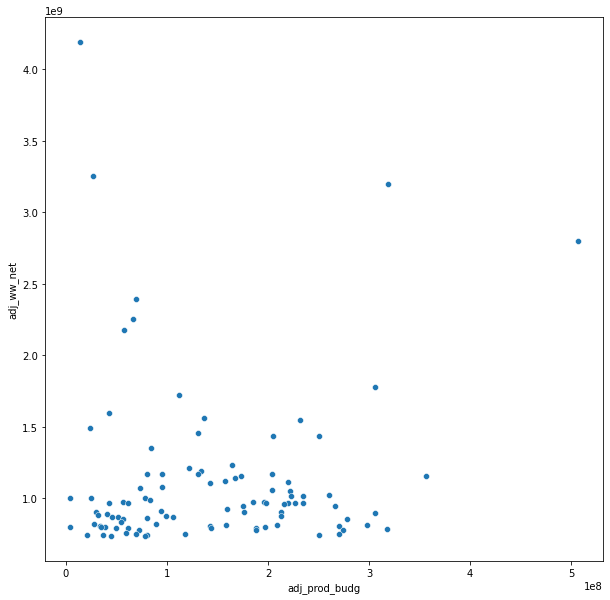

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.scatterplot(data=top100_net_films, x="adj_prod_budg", y="adj_ww_net")
plt.show()

In [34]:
title_roi = df[['title','adj_prod_budg', 'adj_ww_gross', 'adj_ww_roi', 'year']]
unique_titles = title_roi.groupby('title').first().reset_index()
top20_roi_films = unique_titles.sort_values(by='adj_ww_roi', ascending=False).head(20)
top20_roi_films

,title,adj_prod_budg,adj_ww_gross,adj_ww_roi,year
1909,Mad Max,6.205267e+05,3.094877e+08,497.750000,1980
2303,Paranormal Activity,5.362509e+05,2.314018e+08,430.517853,2009
3294,The Gallows,1.078644e+05,4.493251e+07,415.564740,2015
3090,The Blair Witch Project,9.207335e+05,3.810302e+08,412.833333,1999
2936,Super Size Me,8.797091e+04,3.009121e+07,341.058585,2004
352,Bambi,1.345728e+07,4.203440e+09,311.354312,1942
996,El Mariachi,1.238477e+04,3.612686e+06,290.704000,1993
2557,Rocky,4.493093e+06,1.010946e+09,224.000000,1976
3129,The Brothers McMullen,8.387697e+04,1.749087e+07,207.530120,1995
3797,The Texas Chainsaw Massacre,7.260037e+05,1.377978e+08,188.803136,1974


In [35]:
a_g = df[['title', 'actors', 'genres']]
a_g

,title,actors,genres
0,Percy Jackson & the Olympians: The Lightning T...,"Logan Lerman, Brandon T. Jackson, Alexandra Da...","Action & Adventure, Comedy, Drama, Science Fic..."
1,Please Give,"Catherine Keener, Amanda Peet, Oliver Platt, R...",Comedy
2,"10,000 B.C.","Steven Strait, Camilla Belle, Cliff Curtis, Jo...","Action & Adventure, Classics, Drama"
3,3:10 to Yuma,"Glenn Ford, Van Heflin, Felicia Farr, Leora Da...","Classics, Drama, Western"
4,Dark Water,"Hitomi Kuroki, Rio Kanno, Shigemitsu Ogi, Mire...","Art House & International, Horror, Mystery & S..."
...,...,...,...
4771,Zoolander,"Ben Stiller, Owen Wilson, Will Ferrell, Christ...","Comedy, Special Interest"
4772,Zoolander 2,"Ben Stiller, Owen Wilson, Will Ferrell, Penelo...",Comedy
4773,Zoom,"Tim Allen, Courteney Cox, Chevy Chase, Spencer...","Action & Adventure, Comedy, Kids & Family"
4774,Zootopia,"J.K. Simmons, Kristen Bell, Octavia Spencer, A...","Action & Adventure, Animation, Comedy"


In [36]:
df[df.title == 'Titanic']

,idx,rotten_tomatoes_link,title,movie_info,critics_consensus,rating,genres,directors,authors,actors,...,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_prod_budg,adj_dom_net,adj_ww_net,adj_i_net,adj_dom_roi,adj_ww_roi,adj_i_roi
367,1017,m/1056130-titanic,Titanic,"Stuck in an unloving marriage, rich socialite ...",None,NR,"Action & Adventure, Classics, Drama, Romance",Jean Negulesco,"Charles Brackett, Walter Reisch, Richard L. Breen","Clifton Webb, Barbara Stanwyck, Robert Wagner,...",...,1.050287e+09,3.517408e+09,2.467121e+09,3.185757e+08,7.317110e+08,3.198832e+09,2.148545e+09,2.29682,10.041042,6.744222
4407,16297,m/titanic,Titanic,"James Cameron's ""Titanic"" is an epic, action-p...",A mostly unqualified triumph for James Cameron...,PG-13,"Drama, Romance",James Cameron,James Cameron,"Leonardo DiCaprio, Kate Winslet, Billy Zane, K...",...,1.050287e+09,3.517408e+09,2.467121e+09,3.185757e+08,7.317110e+08,3.198832e+09,2.148545e+09,2.29682,10.041042,6.744222


In [37]:
leo_adj_gross = df[df['actors'].str.contains('Leonardo DiCaprio')].adj_ww_gross.sum()
leo_adj_gross

8549676140.516123

In [62]:
# split_list = []
# for actor in df.actors:
#     split_list += actor.split(',')
    
# actors = list(set(split_list))

actor_list = ['Robert Downey Jr.',
 'Dwayne Johnson',
 'Chris Evans',
 'Chris Hemsworth',
 'Mark Ruffalo',
 'Johnny Depp',
 'Chris Pratt',
 'Vin Diesel',
 'Jason Statham',
 'Samuel L. Jackson',
 'Mark Wahlberg',
 'Liam Hemsworth',
 'Tom Hardy',
 'Ian McKellen',
 'Josh Hutcherson',
 'Steve Carell',
 'Will Smith',
 'Ryan Reynolds',
 'Michael Keaton',
 'Woody Harrelson',
 'Leonardo DiCaprio',
 'Kevin Hart',
 'Martin Freeman',
 'Liam Neeson',
 'Hugh Jackman',
 'Andy Serkis',
 'Richard Armitage',
 'Bradley Cooper',
 'Jesse Eisenberg',
 'Idris Elba',
 'Channing Tatum',
 'Matt Damon',
 'Chiwetel Ejiofor',
 'Gary Oldman',
 'Daniel Craig',
 'Bryan Cranston',
 'Chris Pine',
 'James McAvoy',
 'Seth Rogen',
 'Owen Wilson',
 'Tom Hiddleston',
 'Jeremy Renner',
 'Kevin James',
 'Jack Black',
 'Christoph Waltz',
 'Tom Hanks',
 'Ken Watanabe',
 'Tom Cruise',
 'Adam Sandler',
 'Ben Affleck',
 'Ralph Fiennes',
 'Ben Kingsley',
 'Jamie Foxx',
 'Michael B. Jordan',
 'Matthew McConaughey',
 'Paul Walker',
 'Javier Bardem',
 'Ben Mendelsohn',
 'Michael Fassbender',
 'Don Cheadle',
 'Willem Dafoe',
 'Gerard Butler',
 'Jason Momoa',
 'Josh Brolin',
 'Jude Law',
 'Josh Duhamel',
 'Will Arnett',
 'Stanley Tucci',
 'Christian Bale',
 'Russell Crowe',
 'Jason Bateman',
 'Antonio Banderas',
 'Ben Stiller',
 'Geoffrey Rush',
 'Jay Baruchel',
 'Donald Glover',
 'Andrew Garfield',
 'Benjamin Bratt',
 'Ian McShane',
 'Anthony Hopkins',
 'Jonah Hill',
 'Benedict Cumberbatch',
 'Donnie Yen',
 'T.J. Miller',
 'Eddie Redmayne',
 'Henry Cavill',
 'James Earl Jones',
 'Josh Gad',
 'Brad Pitt',
 'Ty Simpkins',
 'Zach Galifianakis',
 'John Goodman',
 'Jon Hamm',
 'Patrick Wilson',
 'Joseph Gordon-Levitt',
 'Morgan Freeman',
 'Irrfan Khan',
 'Marwan Kenzari',
 'Neil Patrick Harris',
 'Robert De Niro']

gross = []
for name in actor_list:
    value = df[df['actors'].str.contains(name)].adj_ww_gross.sum()
    gross.append(value)
    
    
gross[:5]


[11347372028.952734,
 10805639553.785833,
 8573423129.69062,
 7718332727.016749,
 7046639100.414162]

In [65]:
dict = {'Actor': actor_list, 'Gross': gross}
gross_df = pd.DataFrame(dict)
top20_actors = gross_df.sort_values(by='Gross', ascending=False).head(20)
top20_actors

,Actor,Gross
9,Samuel L. Jackson,1.942438e+10
13,Ian McKellen,1.386912e+10
45,Tom Hanks,1.327989e+10
25,Andy Serkis,1.271168e+10
67,Stanley Tucci,1.179104e+10
29,Idris Elba,1.149784e+10
95,Morgan Freeman,1.147837e+10
0,Robert Downey Jr.,1.134737e+10
47,Tom Cruise,1.095744e+10
59,Don Cheadle,1.091139e+10


In [57]:
split_list = []
for actor in df.actors:
    split_list += actor.split(',')
    
actors = list(set(split_list))
actors[:5]

collected = []
for actor in actors:
    actor = actor.strip()
    collected.append(actor)
collected[:5]

['Ziah Colón', 'Tom Equin', 'Ed Bruce', 'Brian Keith Lewis', 'Laurie Main']

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


error: nothing to repeat at position 0

In [ ]:
split_list = []
for genre in df.genres:
    split_list += genre.split(',')

raw_genres = list(set(split_list))
raw_genres

In [ ]:
split_list = []
for genre in df.genres:
    split_list += [g.strip().lower() for g in genre.split(',')]
    
genres = list(set(split_list))
genres

In [ ]:
len(genres)

In [ ]:
action = df[(df['genres'] == 'Action & Adventure')]
unique_titles = action.groupby('title').first().reset_index()
top100_action = unique_titles.sort_values(by='adj_ww_net', ascending=False)
top100_action

In [ ]:
scifi.groupby('title').first().reset_index()

In [ ]:
scifi = df[(df['genres'].str.contains('science fiction & fantasy', case=False))]
unique_titles = scifi.drop_duplicates(subset = ['title'])
top100_scifi = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(100)
top100_scifi

In [ ]:
list(df[df['title'] == 'Mad Max'].genres)